## Import libs

** note1 import py does not work on Colab
** note2 confliction tensorflow version requirements for libs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/SMFAI/src
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import torch
import shutil
import numpy as np
import pandas as pd
from utils import *
from PIL import Image

import torchvision
from IPython.core.display import Video
from moviepy.editor import *
import moviepy.video.fx.all as vfx
from moviepy.video.fx.all import crop, resize
import ffmpeg

import json
import argparse
import pickle
import random
import os
import subprocess

from tqdm import tqdm
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SMFAI/src


## Sys Test - custom video

1. upload videoPath, clothID
2. process video
3. process cloth
4. create pairs
5. process required inputs
6. warping cloth
7. try on overlay
8. create video

## inputs

In [ ]:
# cloth index
clothID = 0

# user defined video input
video = '../data/raw/tryOnVideo_women.mp4'
showColabVideo(video)

## process data

/content/drive/MyDrive/SMFAI/src
[MoviePy] >>>> Building video ../data/processed/tryOnVideo.mp4
[MoviePy] Writing video ../data/processed/tryOnVideo.mp4


 98%|█████████▊| 40/41 [00:04<00:00,  8.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../data/processed/tryOnVideo.mp4 

[MoviePy] >>>> Building video ../data/input/tryOnVideo.mp4
[MoviePy] Writing video ../data/input/tryOnVideo.mp4


 98%|█████████▊| 40/41 [00:04<00:00,  9.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../data/input/tryOnVideo.mp4 

/content/drive/MyDrive/SMFAI/lib/humanParsing
Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
100% 39/39 [00:02<00:00, 17.46it/s]
/content/drive/MyDrive/SMFAI/src


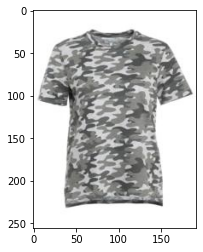

In [ ]:
%cd /content/drive/MyDrive/SMFAI/src

# maskRCNN
processCloth(raw_cloth_DIR, cloth_DIR, cloth_mask_DIR)
# CMU openPose https://github.com/CMU-Perceptual-Computing-Lab/openpose
getOpenPose(video, 0,4)
# show cloth
_=plt.imshow(cv.imread(os.path.join(cloth_DIR, \
                                    testPairsTxt(clothID, img_frames_DIR, cloth_DIR).iloc[0,1]))[:,:,::-1])

# https://github.com/GoGoDuck912/Self-Correction-Human-Parsing
%cd /content/drive/MyDrive/SMFAI/lib/humanParsing
!pip install ninja
!python parse.py --dataset 'pascal' \
--model-restore 'model_Schp_pascal.pth' \
--input-dir '../../data/processed/image' \
--output-dir 'pascal'

# read processed inputs
%cd /content/drive/MyDrive/SMFAI/src
getImageParse()
getImageMask(img_frames_DIR, parsed_img_DIR, image_mask_DIR)
getImageParseNew(parsed_img_DIR ,img_parse_new_DIR)

## try on - cp-vton-plus

In [ ]:
# warping
%cd /content/drive/MyDrive/SMFAI/src
tryOnInputGen(cpVtonPlusDIR)
%cd /content/drive/MyDrive/SMFAI/lib/cpVtonPlus
!pip install tensorboardX
!pip install torchvision==0.2.1
!python test.py --name 'GMM' \
--gpu_ids 'None' \
--batch-size 4 \
--dataroot 'data' \
--datamode 'test' \
--stage 'GMM' \
--data_list 'testPairs.txt' \

# move data
src_warp_cloth = 'result/GMM/test/warp-cloth'
src_warp_mask = 'result/GMM/test/warp-mask'
dest_warp_cloth = 'data/test/warp-cloth'
dest_warp_mask = 'data/test/warp-mask'
if os.path.exists(dest_warp_cloth):
    shutil.rmtree(dest_warp_cloth)
if os.path.exists(dest_warp_mask):
    shutil.rmtree(dest_warp_mask)
shutil.copytree(src_warp_cloth, dest_warp_cloth)
shutil.copytree(src_warp_mask, dest_warp_mask)

# try on
!python test.py \
--name TOM \
--stage TOM \
--workers 2 \
--datamode test \
--data_list testPairs.txt \
--checkpoint models/tom_final.pth

/content/drive/MyDrive/SMFAI/src
/content/drive/MyDrive/SMFAI/lib/cpVtonPlus
Namespace(batch_size=4, checkpoint='models/gmm_final.pth', data_list='testPairs.txt', datamode='test', dataroot='data', display_count=1, fine_height=256, fine_width=192, gpu_ids='None', grid_size=5, name='GMM', radius=5, result_dir='result', shuffle=False, stage='GMM', tensorboard_dir='tensorboard', workers=1)
Start to test stage: GMM, named: GMM!
initialization method [normal]
initialization method [normal]
step:        1, time: 0.735
step:        2, time: 0.663
step:        3, time: 0.639
step:        4, time: 0.637
step:        5, time: 0.671
step:        6, time: 0.662
step:        7, time: 0.677
step:        8, time: 0.680
step:        9, time: 0.595
step:       10, time: 0.460
Finished test GMM, named: GMM!
Namespace(batch_size=4, checkpoint='models/tom_final.pth', data_list='testPairs.txt', datamode='test', dataroot='data', display_count=1, fine_height=256, fine_width=192, gpu_ids='', grid_size=5, name=

In [ ]:
#result
%cd /content/drive/MyDrive/SMFAI/src
out_video = getTryOnVideo(out_tryOn_DIR)
showColabVideo(out_video)

/content/drive/MyDrive/SMFAI/src
[MoviePy] >>>> Building video ../result/out_tryOnVideo_0.mp4
[MoviePy] Writing video ../result/out_tryOnVideo_0.mp4


100%|██████████| 40/40 [00:00<00:00, 317.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../result/out_tryOnVideo_0.mp4 

